## Hog Feature Project

The goals / steps of this project are the following:

* Compute the hog feature.
* Test hog feature on show.
* Classified cars through SVM trained by hog features.

Reference

[1] Histograms of Oriented Gradients for Human Detection https://hal.inria.fr/file/index/docid/548512/filename/hog_cvpr2005.pdf 

[2] Histograms of Oriented Gradients for Human Detection https://tel.archives-ouvertes.fr/tel-00390303/document

[3] scikit-image/skimage/feature/_hog.py https://github.com/scikit-image/scikit-image

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
%matplotlib inline

## Show Function Definition

In [2]:
def show_images(images,lable = None,cols = 3,cmap = None,ticksshow = True):
    
    rows = (len(images)+cols-1)//cols 
    
    plt.figure(figsize=(14, 14))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        
        # use gray scale color map if there is only one channel   
        showimage_shape = image.shape

        if len(showimage_shape) == 2: 
            cmap = "gray"
        elif  showimage_shape[2] == 1:
            image = image[:,:,0]
            cmap = "gray"
        
        plt.imshow(image, cmap=cmap)
        if lable != None and lable[i] != None:
            plt.title(lable[i],fontsize=12)
            
        if ticksshow != True:
            plt.xticks([])
            plt.yticks([])
            
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

def show_histograms(images,cols = 3):
    
    rows = (len(images)+cols-1)//cols 
    
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(rows, cols, i+1)
        
        plt.bar(images[i][0], images[i][1])
        plt.title(images[i][2])
        
    plt.show()
    
def show_histogram(x,y,title=""):
    plt.figure()
    plt.bar(x, y)
    plt.title(title)
    plt.show()

## Hog Feature 

* Compute gradien magnitude and angle of image.
* Compute cell gradient histogram.
* compute normalize block.
* Compute hog feature and Flatten hog features.

### Compute gradien magnitude and angle of image.

The first step of calculation is the computation of the gradient values,using the following formula:

$ G_x(x,y)=I(x+1,y)-I(x-1,y) $

$ G_y(x,y)=I(x,y+1)-I(x,y-1) $

$ G(x,y)= \sqrt{G_x(x,y)^2 + G_y(x,y)^2} $

$ Deg(x,y)=tan^{-1}({G_y(x,y) \over G_x(x,y)} ) $

In [3]:
##
#   calculate gradient magnitude and gradient angle for image using sobel 
##
def calc_gradient(img,sobel_kernel=3):
     # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Calculate the gradient angle
    grad= cv2.phase(sobelx, sobely, angleInDegrees=True)
    
    return gradmag, grad

### Compute cell gradient histogram.

The second step of calculation is creating the cell histograms. Each pixel within the cell casts a weighted vote for an orientation-based histogram channel based on the values found in the gradient computation. 

The cell histogram channels are spread over 0 to 180 degrees or 0 to 360 degrees if signed_orientation.Histogram channels are divided into `orientations` parts corresponding to `orientation_centers` index.

For exmaple,one cell magnitude are voted to gradient angle,shown as `min_angle_index` and `max_angle_index` by calculated `factor` distance.

![](resources/gradient_histogram.jpg)

In [4]:
##
#   calculate cell gradient histogram
##
def calc_cell_gradient(cell_magnitude, cell_angle,orientations,signed_orientation=False):
    
    orientation_centers = np.arange(orientations)
    orientations_mag = np.zeros(orientations)

    height = cell_magnitude.shape[0]
    width = cell_magnitude.shape[1]
    
    if signed_orientation:
        max_angle = 360
    else:
        max_angle = 180
    
    for x in range(width):
        for y in range(height):
            gradient_strength = cell_magnitude[y][x]
            gradient_angle = cell_angle[y][x]
            
            gradient_angle_norm = (gradient_angle % max_angle) / (max_angle / orientations)
            
            min_angle_index = 0
            max_angle_index = 0
    
            for angle in orientation_centers:
                if np.abs(gradient_angle_norm - angle) <= 1.0:
                    min_angle_index = angle
                    break
            
            if min_angle_index == orientation_centers[-1]:
                max_angle_index = 0
            else:
                max_angle_index = min_angle_index + 1
            
            factor = abs(gradient_angle_norm - min_angle_index)
            
            # Cell magnitude are voted to gradient angle
            orientations_mag[min_angle_index] += gradient_strength * (1-factor)
            orientations_mag[max_angle_index] += gradient_strength * (factor)
                
    return orientations_mag

### Compute normalize block.

L2-norm: $ f={v \over { \sqrt{||v||_2^2 + e^2} }}$

L2-hys: L2-norm followed by clipping (limiting the maximum values of v to 0.2) and renormalizing,

L1-norm: $ f={v \over { \sqrt{||v||_1 + e} }}$

L2-sqrt: $ f= \sqrt{v \over {||v||_1 + e} }$

In [5]:
##
#   calculate hog normalize block
##

def _hog_normalize_block(block, method="L1", eps=1e-5):
    if method == 'L1':
        out = block / (np.sum(np.abs(block)) + eps)
    elif method == 'L1-sqrt':
        out = np.sqrt(block / (np.sum(np.abs(block)) + eps))
    elif method == 'L2':
        out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
    elif method == 'L2-Hys':
        out = block / np.sqrt(np.sum(block ** 2) + eps ** 2)
        out = np.minimum(out, 0.2)
        out = out / np.sqrt(np.sum(out ** 2) + eps ** 2)
    else:
        raise ValueError('Selected block normalization method is invalid.')

    return out

### Compute hog feature and Flatten hog features.

* Convert origin image to gray.(multichannel may be uesed.)
* Compute gradien magnitude and angle of image.
* Compute cell gradient histogram.
* compute normalize block.
* Flatten hog features.
* show hog feature images.

One cell contains `pixels_per_cell` pixels.

One block contains `cells_per_block` cells

![](resources/hog.jpg)

In [6]:
def hog_detector(image,pixels_per_cell=(8, 8),cells_per_block=(2, 2),orientations=9,visualise=False,signed_orientation=False):
    
    #Convert origin image to gray
    if len(image.shape) == 2 or image.shape[2] == 1: 
        img = image
    else:
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
    height = img.shape[0]
    width = img.shape[1]
    
    gradient_magnitude, gradient_angle = calc_gradient(img)
    
    if visualise == True:
        show_images([img,gradient_magnitude,gradient_angle],['origin','magnitude','angle'],cols = 3)
    
    cx,cy = pixels_per_cell
    b_row, b_col = cells_per_block
    
    hog_vector = []
    num_horizontal_blocks = int(width // cx)
    num_vertical_blocks = int(height // cy)
    
    #cell orientation histogram
    orientation_histogram = np.zeros((num_vertical_blocks, num_horizontal_blocks, orientations))
    
    for x in range(num_horizontal_blocks):
        for y in range(num_vertical_blocks):
            cell_magnitude = gradient_magnitude[y*cy:(y+1)*cy-1, x*cx:(x+1)*cx-1]
            cell_angle = gradient_angle[y*cy:(y+1)*cy-1, x*cx:(x+1)*cx-1]
            
            orientation_centers = calc_cell_gradient(cell_magnitude,cell_angle,orientations)
            
            orientation_histogram[y,x,:] = orientation_centers
    
    #show hog features
    if visualise == True:
        radius = min(cx, cy) // 2 - 1
        hog_image = np.zeros((height, width), dtype=np.uint8)
        cell_image = np.copy(img)
        
        if signed_orientation:
            max_angle = 360
        else:
            max_angle = 180
        
        
        for x in range(num_horizontal_blocks):
            for y in range(num_vertical_blocks):
                angle = 0
                angle_gap = max_angle/orientations

                scale_factor = np.max(orientation_histogram[y,x,:])
                
                if scale_factor > 0:
                    normscale = (orientation_histogram[y,x,:]/scale_factor).astype(np.float)
                else:
                    normscale = orientation_histogram[y,x,:]
                
                centre = tuple([y * cy + cy // 2, x * cx + cx // 2])
                
                x_start = int(centre[0] - cy // 2)
                y_start = int(centre[1] - cx // 2)
                x_stop = int(centre[0] + cy // 2)
                y_stop = int(centre[1] + cx // 2)

                cv2.rectangle(cell_image, (y_start, x_start), (y_stop, x_stop), 255)
                    
                
                for d in range(orientations):
                    magnitude = normscale[d] 

                    dx = magnitude*radius*math.cos(angle)
                    dy = magnitude*radius*math.sin(angle)

                    x1 = int(centre[0] - dx)
                    y1 = int(centre[1] + dy)
                    x2 = int(centre[0] + dx)
                    y2 = int(centre[1] - dy)
                    
                    cv2.line(hog_image, (y1, x1), (y2, x2), 255)
                    
                    angle += angle_gap
                    
        newimg = cv2.addWeighted(img, 0.5, hog_image, 0.5, 0)
        
        show_images([cell_image,hog_image,newimg],['celled image','hog image','combined image show'],cols = 3)

    
    #compute normalize block.
    n_blocks_row = (num_vertical_blocks- b_row) + 1
    n_blocks_col = (num_horizontal_blocks - b_col) + 1
    normalized_blocks = np.zeros((n_blocks_row, n_blocks_col,b_row, b_col, orientations))
    
    for r in range(n_blocks_row):
        for c in range(n_blocks_col):
            block = orientation_histogram[r:r + b_row, c:c + b_col, :]
            normalized_blocks[r, c, :] =  _hog_normalize_block(block)

    #show histogram of cell original and block normalized
    if visualise == True:
        
        show_histogram_vector = []
        
        for x in range(b_row):
            for y in range(b_col):
                show_histogram_vector.append([np.arange(orientations),orientation_histogram[y,x,:],\
                                              "original ({:d},{:d})".format(y,x)])
          
        for x in range(b_row):
            for y in range(b_col):
                show_histogram_vector.append([np.arange(orientations),normalized_blocks[0,0,y,x,:],\
                                              "normalized ({:d},{:d})".format(y,x)])
        
        show_histograms(show_histogram_vector,cols=b_row*b_col)
    
    #Flatten hog features and return
    return normalized_blocks.ravel()

## Hog Feature Test and Show 

imge size is (63, 106, 3)


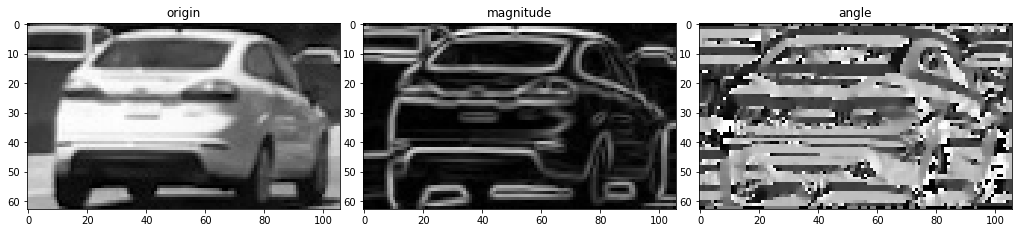

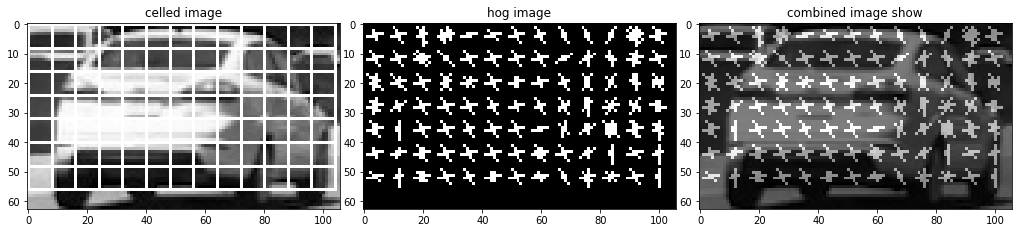

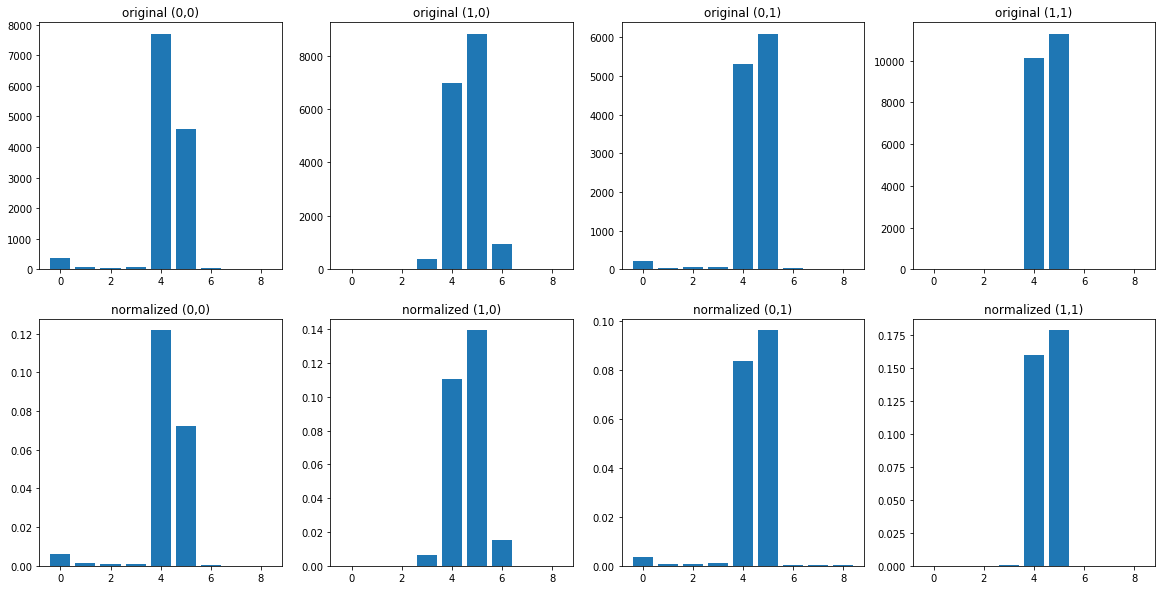

hog feature size is 2592


In [7]:
imge = cv2.imread('test.jpg')
print("imge size is ",end="")
print(imge.shape)

res = hog_detector(imge,visualise=True)
print("hog feature size is ",end="")
print(len(res))

## Classified cars through SVM trained by hog features.

### Read dataset of small car

Your function returned a count of 1196  cars and 1125  non-cars
Image of size:  (64, 64, 3)  and data type: uint8


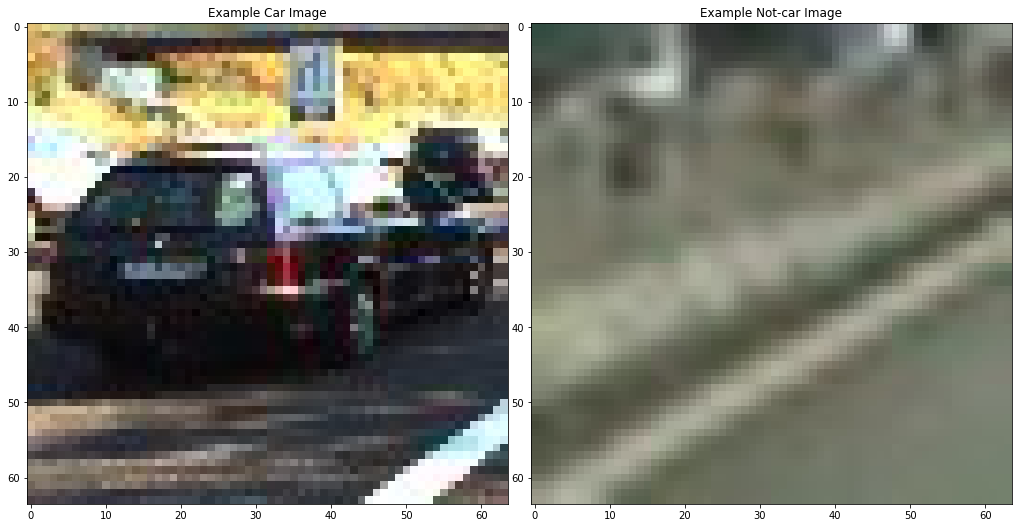

In [8]:
# images are divided up into vehicles and non-vehicles
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
import os
import glob
import math
%matplotlib inline

carimages = glob.glob('resources/vehicles_smallset/*/*.jpeg')
notcarimages = glob.glob('resources/non-vehicles_smallset/*/*.jpeg')

cars = []
notcars = []

for image in carimages:
    cars.append(image)

for image in notcarimages:
    notcars.append(image)
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('Image of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

show_images([car_image,notcar_image],['Example Car Image','Example Not-car Image'],cols = 2)

### Train and Test Hog Features

In [11]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn import svm, datasets,grid_search
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.imread(file)
        hog_features = hog_detector(image,pixels_per_cell=(pix_per_cell, pix_per_cell),\
                                    cells_per_block=(cell_per_block, cell_per_block),orientations=orient)
        
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

#parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


#train svm
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

72.65 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1764
40.08 Seconds to train SVC...
Test Accuracy of SVC =  0.9806
My SVC predicts:  [ 0.  0.  1.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  0.  1.  1.  1.]
0.01955 Seconds to predict 10 labels with SVC
